<a href="https://colab.research.google.com/github/denizmsayin/singan/blob/master/run.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import subprocess as sp
from time import time

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

torch.__version__

'1.5.0+cu101'

## Notes
- Every generator and critic at every scale has the same architecture, with 5 Conv(3x3)-BN-LReLU layers.
- The patch size is given as 11x11, which comes from the receptive field of the 5 layer deep network.
- How the number of kernels change is not exactly clear, paper says "start with 32, double once every 4 scales"
- It is not clear whether the conv layers use padding (zero, reflect?) to preserve size or not. We assume for now that the generators do preserve the size, but it does not seem necessary for the critics.
- How the downsampling is done is not clear from the paper. We assume bicubic interpolation.
- For the coarsest scale, authors say that "the effective receptive field at this level is typically∼1/2of the image’s height". ~~We assume that this means the input size at the coarsest scale is somewhere between 20 and 25 pixels.~~ The authors later state that they use 25 px for the coarsest and 250 pixels for the finest scale along with a rescaling ratio of 4/3. 
- Lots of training details are given in the supplementary material.
- It is not clear 

In [0]:
def prepare_bsds300():
  if os.path.isdir('BSDS300'):
    print('Dataset already downloaded')
  else:
    sp.call(('wget', 'https://www2.eecs.berkeley.edu/Research/Projects/CS/vision/bsds/BSDS300-images.tgz'))
    sp.call(('tar', '-xvzf', 'BSDS300-images.tgz'))
    sp.call(('rm', '-f', 'BSDS300-images.tgz'))
    print('Downloaded dataset successfully')

In [0]:
class Conv2DBlock(nn.Module):
  """ Combine Conv2d-BN-LReLU into a single block """
  # the 0.2 negative slope is given in the supplementary materials
  def __init__(self, in_channels, out_channels, kernel_size, activation, conv_kwargs={}, bn_kwargs={}):
    super().__init__()
    self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, **conv_kwargs)
    self.bn = nn.BatchNorm2d(out_channels, **bn_kwargs)
    self.activ = activation

  def forward(self, x):
    return self.activ(self.bn(self.conv(x)))

class SGNet(nn.Module):
  def __init__(self, output_channels=3, kernel_count=32, final_activation=nn.Tanh(), final_bn=True, num_blocks=5):
    super().__init__()
    self.layers = nn.ModuleList()
    self.layers.append(nn.ZeroPad2d(num_blocks)) # initial padding, as explained in the SM
    in_channels = 3
    for _ in range(num_blocks-1): # multiple Conv2D blocks with LeakyReLU
      self.layers.append(Conv2DBlock(in_channels, kernel_count, 3, nn.LeakyReLU(negative_slope=0.2)))
      in_channels = kernel_count
    # the final activation depends on whether this is the generator or critic
    if final_bn:
      self.layers.append(Conv2DBlock(kernel_count, output_channels, 3, final_activation))
    else:
      self.layers.append(nn.Conv2d(kernel_count, output_channels, 3))
      self.layers.append(final_activation)

  def forward(self, x):
    for layer in self.layers:
      x = layer(x)
    return x

class Mean(nn.Module):
  def __init__(self):
    super().__init__()

  def forward(self, x):
    return torch.mean(x)
  

Dataset already downloaded


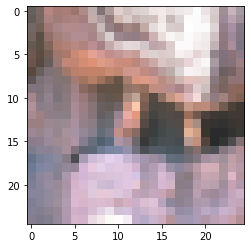

In [4]:
prepare_bsds300()

DS_DIR = 'BSDS300/images/train'
EXAMPLE_IDX = 11
IMG_LIST = sorted(os.listdir(DS_DIR))
EXAMPLE_IMG_PATH = os.path.join(DS_DIR, IMG_LIST[EXAMPLE_IDX])

orig_img_uint = np.array(Image.open(EXAMPLE_IMG_PATH).resize((25, 25), Image.BICUBIC))
plt.imshow(orig_img_uint)

In [0]:
# as given in the paper (LR decrease not implemented)
LEARNING_RATE = 0.005
BETA_1 = 0.5
BETA_2 = 0.999
NUM_ITERS = 2000
GEN_STEP_PER_ITER = 3
DIS_STEP_PER_ITER = 3
REC_ALPHA = 10.0
GP_WEIGHT = 0.1

PRINT_EVERY = 50

torch.Size([1, 3, 25, 25])
Step: 0


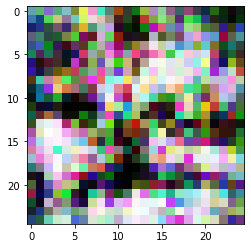

Step: 50
Steps per second: 3.54


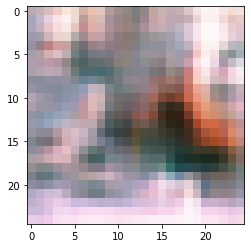

Step: 100
Steps per second: 3.51


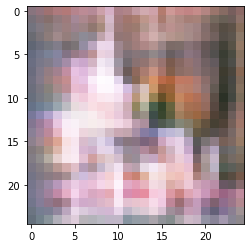

Step: 150
Steps per second: 3.53


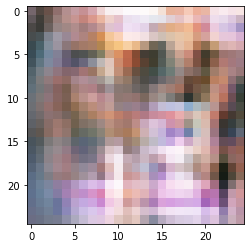

Step: 200
Steps per second: 3.52


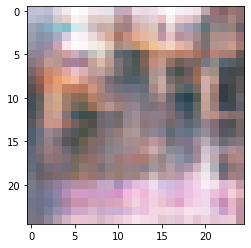

Step: 250
Steps per second: 3.52


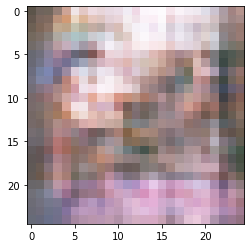

Step: 300
Steps per second: 3.49


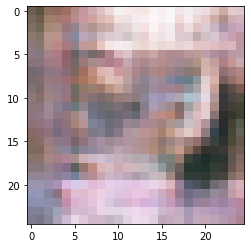

Step: 350
Steps per second: 3.50


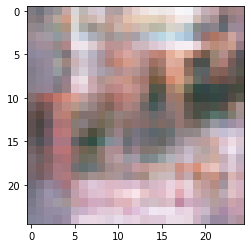

Step: 400
Steps per second: 3.51


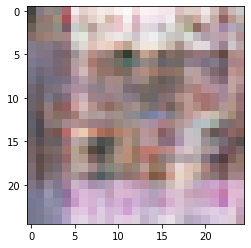

Step: 450
Steps per second: 3.52


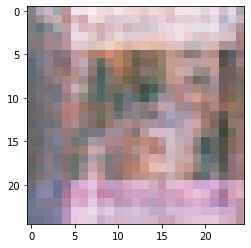

Step: 500
Steps per second: 3.52


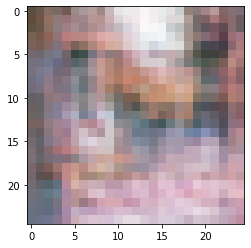

Step: 550
Steps per second: 3.52


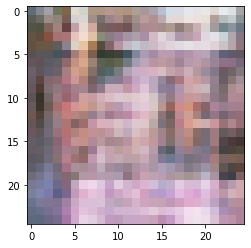

Step: 600
Steps per second: 3.51


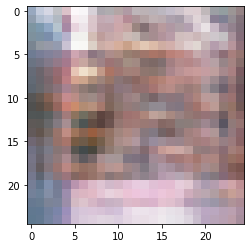

Step: 650
Steps per second: 3.51


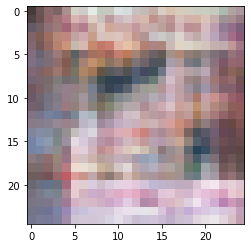

Step: 700
Steps per second: 3.50


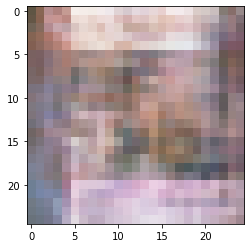

Step: 750
Steps per second: 3.51


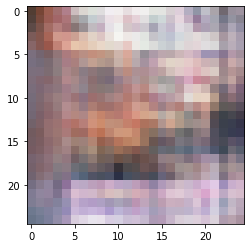

Step: 800
Steps per second: 3.52


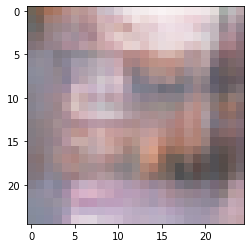

Step: 850
Steps per second: 3.51


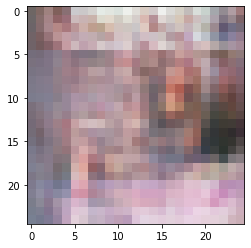

Step: 900
Steps per second: 3.52


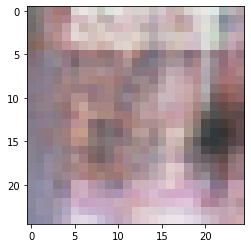

Step: 950
Steps per second: 3.49


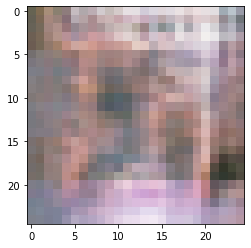

Step: 1000
Steps per second: 3.52


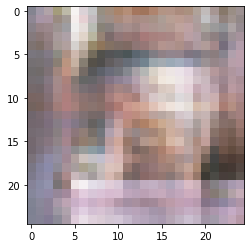

Step: 1050
Steps per second: 3.47


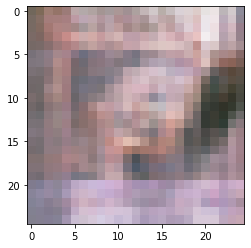

Step: 1100
Steps per second: 3.51


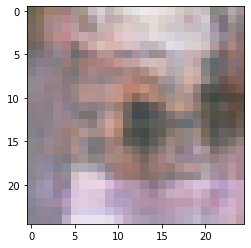

Step: 1150
Steps per second: 3.48


In [0]:


def img2net(img_uint):
  # convert [0, 255] uint8 (H, W, C) to [-1, 1] float32 (1, C, H, W)
  rescaled = (img_uint.astype('float32') / 127.5) - 1.0
  chw = np.transpose(rescaled, (2, 0, 1))
  return torch.from_numpy(np.expand_dims(chw, axis=0))

def net2img(img_float):
  chw = np.squeeze(img_float.detach().numpy())
  hwc = np.transpose(chw, (1, 2, 0))
  return ((hwc + 1.0) * 127.5).astype('uint8')

generator = SGNet(output_channels=3)
patch_critic = SGNet(output_channels=1, final_activation=nn.Identity(), final_bn=False)
critic = torch.nn.Sequential(patch_critic, Mean())

gen_optimizer = torch.optim.Adam(generator.parameters(), LEARNING_RATE, (BETA_1, BETA_2))
dis_optimizer = torch.optim.Adam(critic.parameters(), LEARNING_RATE, (BETA_1, BETA_2))

orig_img = img2net(orig_img_uint)
print(orig_img.shape)

def sample_noise():
  return torch.from_numpy(np.random.uniform(-1, 1, size=orig_img.shape).astype('float32'))

z_rec = sample_noise()
mse = nn.MSELoss()

for step in range(NUM_ITERS):

  # real 1, fake 0

  for _ in range(GEN_STEP_PER_ITER):
    gen_optimizer.zero_grad()

    z = sample_noise()
    fake_img = generator(z)

    # adversarial loss
    adv_loss = -critic(fake_img)

    # reconstruction loss
    rec_img = generator(z_rec)
    rec_loss = mse(orig_img, rec_img)

    gen_loss = adv_loss + REC_ALPHA * rec_loss
    gen_loss.backward()
    gen_optimizer.step()

  for _ in range(DIS_STEP_PER_ITER):
    dis_optimizer.zero_grad()

    z = sample_noise()
    fake_img = generator(z)
    epsilon = np.random.uniform(0, 1)

    # adversarial loss
    # take a sample from the line between the real and generated images
    # for use in the gradient penalty (Impr. Training of WGANs)
    grad_sample = epsilon * orig_img + (1 - epsilon) * fake_img
    f_grad_sample = critic(grad_sample)
    grad, = torch.autograd.grad(f_grad_sample, grad_sample, create_graph=True)
    grad_loss = (torch.norm(grad) - 1)**2

    adv_loss = critic(fake_img) - critic(orig_img) + GP_WEIGHT * grad_loss
    adv_loss.backward()
    dis_optimizer.step()

  if step % PRINT_EVERY == 0:
    print('Step: {}'.format(step))
    if step != 0:
      elapsed = time() - last_print
      print('Steps per second: {:.2f}'.format(PRINT_EVERY / elapsed))
    plt.imshow(net2img(fake_img))
    plt.show()
    last_print = time()

plt.imshow(net2img(generator(z_rec)))
plt.show()
